In [1]:
#Note: this notebook is like graph1, but it will specifically process particular tokens in the loss_per_token_scored.csv file

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
!echo $CONDA_DEFAULT_ENV

In [3]:
#paths
root_dir = "/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling"
group_folder = "repetition_final"
exp_name= "pile1e8_20len"
dataset_names = [f"{exp_name}_seed0", f"{exp_name}_seed1", f"{exp_name}_seed2", f"{exp_name}_seed3", f"{exp_name}_seed4"]
model_sizes = ["70M"]
scored_file = "loss_per_token_scored.csv"

#these are the tokens that we will be averaging the losses to get our statistic
start_attend = 0
end_attend = 100

experiments = [f"{root_dir}/{group_folder}/{dataset_name}/{model_size}" for model_size in model_sizes for dataset_name in dataset_names]
experiments

['/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed0/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed1/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed2/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed3/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_scaling/repetition_final/pile1e8_20len_seed4/70M']

In [4]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
models

['1_model',
 '2_model',
 '4_model',
 '8_model',
 '16_model',
 '32_model',
 '64_model',
 '128_model',
 '256_model',
 '512_model',
 '1024_model']

In [5]:
def read_file(file_name):
    data = []
    with open(file_name, 'r') as file:
        for line in file:
            row = [eval(element.strip()) for element in line.split(",")]
            data.append(row[start_attend:end_attend])
    return data

In [6]:
experiments_dfs = []
for experiment in experiments:
    model_dfs = []
    for model_type in models:
        model_dfs += [read_file(os.path.join(experiment,  model_type, scored_file))]
    experiments_dfs.append(model_dfs)
print(len(experiments_dfs))
print(len(model_dfs))

5
11


In [7]:

y_axises = []
null_means = []
null_stdev = []
statistic_total = []
for experiment_dfs in experiments_dfs:
    y_axis = []
    null_raw = []
    null_std = []
    statistic_temp = []
    for model_df in experiment_dfs:
        null_raw = model_df[1:]
        #we first average over tokens to get average loss per each example
        null = [statistics.mean(row) for row in null_raw]

        #we then calculate the average and stdev of this null distribution
        mean = statistics.mean(null)
        stdev = statistics.stdev(null)

        statistic = statistics.mean(model_df[0])
        # print(f"statistic = {statistic}, mean = {mean}, stdev = {stdev}")

        statistic_temp += [statistic]

        y_axis += [(statistic - mean) / stdev]
        null_means += [mean]
        null_std += [stdev]
    y_axises.append(y_axis)
    statistic_total.append(statistic_temp)
    null_stdev.append(null_std)

print(len(y_axises[0]))

11


In [15]:
y_axises = np.array(y_axises).reshape(len(dataset_names), -1)

In [20]:
y_axises.mean(axis=0)


array([ 0.18273629, -0.05305495, -0.49796719, -0.90299613, -2.39077403,
       -4.35338129, -5.73971812, -7.3416916 , -7.58963441, -8.03420778,
       -8.42681689])

In [21]:
y_axises.std(axis=0)

array([0.83516296, 0.82725064, 0.49693239, 0.56057527, 0.80187565,
       0.77567669, 0.84429075, 0.16671749, 0.41316931, 0.08421531,
       0.44228806])

In [22]:
null_means = np.array(null_means).reshape(len(dataset_names), -1)

In [23]:
null_means.mean(axis=0)


array([7.67651262, 7.64713256, 7.65838184, 7.65659026, 7.60895822,
       7.60778223, 7.60315123, 7.66708019, 7.7708996 , 7.74395493,
       7.6774196 ])

In [24]:
null_means.std(axis=0)

array([0.02537813, 0.03046761, 0.06017782, 0.08093656, 0.09971898,
       0.10282227, 0.10298067, 0.06175978, 0.06732457, 0.06412981,
       0.0408485 ])

In [25]:
null_stdev = np.array(null_stdev).reshape(len(dataset_names), -1)

In [26]:
null_stdev.mean(axis=0)

array([0.76383457, 0.74943894, 0.75177146, 0.75918641, 0.73840105,
       0.74286604, 0.74607715, 0.75965095, 0.8002395 , 0.78233867,
       0.75603886])

In [28]:
null_stdev.std(axis=0)

array([0.03172252, 0.03463861, 0.0340033 , 0.03238191, 0.04317756,
       0.04970096, 0.03693138, 0.01295075, 0.04614765, 0.02512433,
       0.01005691])

In [29]:
statistic_total = np.array(statistic_total).reshape(len(dataset_names), -1)

In [30]:
statistic_total.mean(axis=0)


array([7.80233595, 7.60262444, 7.27485806, 6.97474513, 5.87244244,
       4.40398068, 3.32483279, 2.08814204, 1.70755435, 1.45827845,
       1.3063187 ])

In [31]:
statistic_total.std(axis=0)

array([0.63622178, 0.62267552, 0.32364154, 0.448632  , 0.60937087,
       0.44652821, 0.58553688, 0.20298163, 0.28227495, 0.16480533,
       0.30316919])

In [32]:
np.array(y_axises)

array([[ 0.90917117,  0.88384153, -0.53120866, -0.44492928, -1.66529807,
        -3.90151892, -4.88905251, -7.13915943, -7.09087092, -7.94494541,
        -7.6577813 ],
       [-0.75255533, -0.57243596, -0.91557719, -0.84801718, -1.24644189,
        -3.25616406, -4.94378496, -7.42000455, -7.6060597 , -7.99107346,
        -8.38000752],
       [ 0.51073175,  0.59420038, -0.51184873, -1.12093052, -2.75401235,
        -4.48382076, -6.89760311, -7.55348242, -7.26258479, -8.10845604,
        -8.47241553],
       [-0.86938779, -1.38805438, -0.95517477, -1.84658402, -3.38111691,
        -4.52556915, -5.37297988, -7.15105269, -7.70278601, -7.96728897,
        -9.01902439],
       [ 1.11572167,  0.21717368,  0.4239734 , -0.25451966, -2.90700095,
        -5.59983355, -6.59517016, -7.44475891, -8.2858706 , -8.15927504,
        -8.60485571]])

In [33]:
averaged = np.array(y_axises).mean(axis=0)
averaged

array([ 0.18273629, -0.05305495, -0.49796719, -0.90299613, -2.39077403,
       -4.35338129, -5.73971812, -7.3416916 , -7.58963441, -8.03420778,
       -8.42681689])

In [34]:
x_axis = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
# x_axis=[256]
# x_axis = [70, 160, 410, 1400]
print(x_axis)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


No handles with labels found to put in legend.


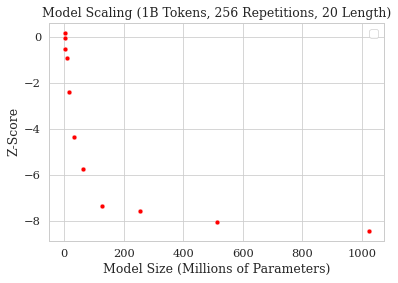

In [36]:
# Create a line plot for each set of y-values
sns.scatterplot(x=x_axis, y=averaged, color='red')

# sns.scatterplot(x=x_axis, y=y_axises[0], color='red', label='70M')
# ax = sns.lineplot(x=x_axis, y=y_axises[1], color='blue', label='160M')
# sns.scatterplot(x=x_axis, y=y_axises[2], color='green', label='30char')

# Customize the plot
plt.title('Model Scaling (1B Tokens, 256 Repetitions, 20 Length)')
plt.xlabel('Model Size (Millions of Parameters)')
plt.ylabel('Z-Score')
plt.legend()

# Show the plot
plt.show()

In [25]:
np.array(y_axises).mean()

-8.709461298761209